In [2]:
import matplotlib.pyplot as plt
import numpy as np

from reservoirpy.datasets import lorenz, doublescroll
from reservoirpy.observables import nrmse
from reservoirpy.nodes import Ridge, NVAR

%matplotlib inline

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from dysts.flows import DoublePendulum
# ------------------------
# Parameters
# ------------------------

# time step duration (in time unit)
dt = 0.025
# training time (in time unit)
train_time  = 100.
# testing time (idem)
test_time   = 50.
# warmup time (idem): should always be > k * s
warm_time   = 20.

# discretization
train_steps = round(train_time / dt)
test_steps  = round(test_time  / dt)
warm_steps  = round(warm_time  / dt)

total_time = train_time + test_time + warm_time
print("Total time: ", total_time)

n_timesteps = train_steps + test_steps + warm_steps
print("Total steps: ", n_timesteps)

model = DoublePendulum()

model.ic = np.array([np.pi / 2, 0.0, np.pi / 2, 0.0])

X = model.make_trajectory(n_timesteps)

print(X.shape)


Total time:  170.0
Total steps:  6800


/home/julien2429/anaconda3/envs/py311/lib/python3.11/site-packages/dysts/base.py:353: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(


(6800, 4)


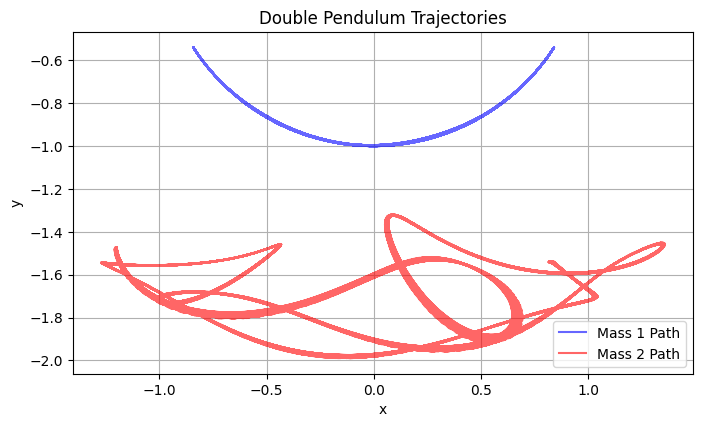

In [4]:

l1 = 1.0  # length of first pendulum
l2 = 1.0  # length of second pendulum

# ------------------------
# Convert to Cartesian: (x1, y1), (x2, y2)
def plot_data(th1, th2):

    # ------------------------
    x1 = l1 * np.sin(th1)
    y1 = -l1 * np.cos(th1)

    x2 = x1 + l2 * np.sin(th2)
    y2 = y1 - l2 * np.cos(th2)

    cartesian_traj = np.stack([x1, y1, x2, y2], axis=1)  # shape: (n_timesteps, 4)

    # ------------------------
    # Plot the trajectory
    # ------------------------
    plt.figure(figsize=(8, 6))
    plt.plot(x1, y1, label='Mass 1 Path', color='blue', alpha=0.6)
    plt.plot(x2, y2, label='Mass 2 Path', color='red', alpha=0.6)
    plt.title("Double Pendulum Trajectories")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_data(X[:,0], X[:,1])


In [13]:
from matplotlib.animation import FuncAnimation, PillowWriter

import matplotlib.pyplot as plt

def make_gif(th1, th2, filename="double_pendulum.gif", l1=1.0, l2=1.0, interval=20):
    """
    Create and save a GIF animation of a double pendulum trajectory.

    Parameters:
        th1, th2: arrays of angles (radians)
        filename: output GIF filename
        l1, l2: pendulum arm lengths
        interval: delay between frames in ms
    """
    x1 = l1 * np.sin(th1)
    y1 = -l1 * np.cos(th1)
    x2 = x1 + l2 * np.sin(th2)
    y2 = y1 - l2 * np.cos(th2)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-2.2, 2.2)
    ax.set_ylim(-2.5, 1.5)
    ax.set_aspect('equal')
    ax.grid(True)
    line1, = ax.plot([], [], 'o-', lw=2, color='blue')
    line2, = ax.plot([], [], 'o-', lw=2, color='red')

    def init():
        line1.set_data([], [])
        line2.set_data([], [])
        return line1, line2

    def update(frame):
        line1.set_data([0, x1[frame]], [0, y1[frame]])
        line2.set_data([x1[frame], x2[frame]], [y1[frame], y2[frame]])
        return line1, line2

    ani = FuncAnimation(fig, update, frames=len(th1), init_func=init, blit=True, interval=interval)
    ani.save(filename, writer=PillowWriter(fps=1000//interval))
    plt.close(fig)


make_gif(theta1_raw, theta2_raw, filename="double_pendulum.gif", l1=l1, l2=l2, interval=20)


NameError: name 'theta1_raw' is not defined

In [5]:
from reservoirpy.nodes import Ridge, NVAR
nvar = NVAR(delay=1, order=2, strides=1) # 6 is good for order
readout = Ridge(4, ridge=0, input_bias=False)

model = nvar >> readout

In [6]:
Xi  = X[:train_steps+warm_steps-1]
dXi = X[1:train_steps+warm_steps] - X[:train_steps+warm_steps-1]

print(f"Xi shape: {Xi.shape}, dXi shape: {dXi.shape}")

model = model.fit(Xi, dXi, warmup=warm_steps)

nvar.run(X[warm_steps+train_steps-2:warm_steps+train_steps])
u = X[warm_steps+train_steps]
res = np.zeros((test_steps, readout.output_dim))
for i in range(test_steps):
    u = u + model(u)
    res[i, :] = u

Xi shape: (4799, 4), dXi shape: (4799, 4)


Running Model-0: 4799it [00:01, 4525.00it/s]<?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Fitting node Ridge-0...


Running NVAR-0: 100%|██████████| 2/2 [00:00<00:00, 3335.43it/s]


(2000, 4)
(2000, 4)


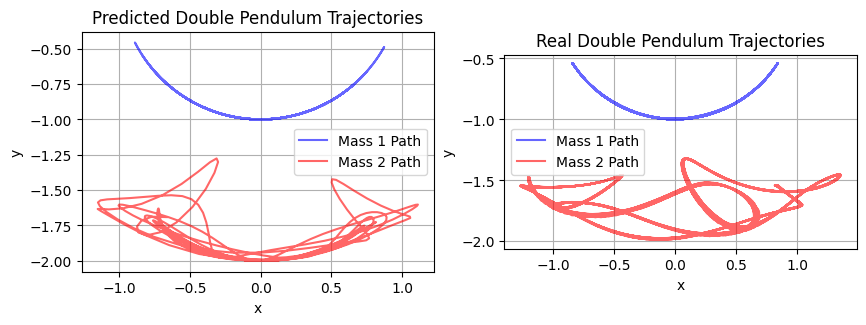

In [7]:
N = test_steps
Y = X[warm_steps+train_steps:]


fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(121)
ax.set_title("Generated pendulum")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.grid(False)

th1 = res[:, 0]
th2 = res[:, 1]
x1 = l1 * np.sin(th1)
y1 = -l1 * np.cos(th1)

x2 = x1 + l2 * np.sin(th2)
y2 = y1 - l2 * np.cos(th2)

cartesian_traj = np.stack([x1, y1, x2, y2], axis=1)  # shape: (n_timesteps, 4)

ax.plot(x1, y1, label='Mass 1 Path', color='blue', alpha=0.6)
ax.plot(x2, y2, label='Mass 2 Path', color='red', alpha=0.6)
ax.set_title("Predicted Double Pendulum Trajectories")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect('equal')
ax.legend()
ax.grid(True)



ax2 = fig.add_subplot(122)
ax2.set_title("Real Double Pendulum Trajectories")
ax2.set_xlabel("$x$")
ax2.set_ylabel("$y$")


th1 = Y[:, 0]
th2 = Y[:, 1]

x1 = l1 * np.sin(th1)
y1 = -l1 * np.cos(th1)

x2 = x1 + l2 * np.sin(th2)
y2 = y1 - l2 * np.cos(th2)

ax2.plot(x1, y1, label='Mass 1 Path', color='blue', alpha=0.6)
ax2.plot(x2, y2, label='Mass 2 Path', color='red', alpha=0.6)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_aspect('equal')
ax2.legend()
ax2.grid(True)

print(res.shape)
print(Y.shape)



In [8]:
%matplotlib widget
import matplotlib.pyplot as plt

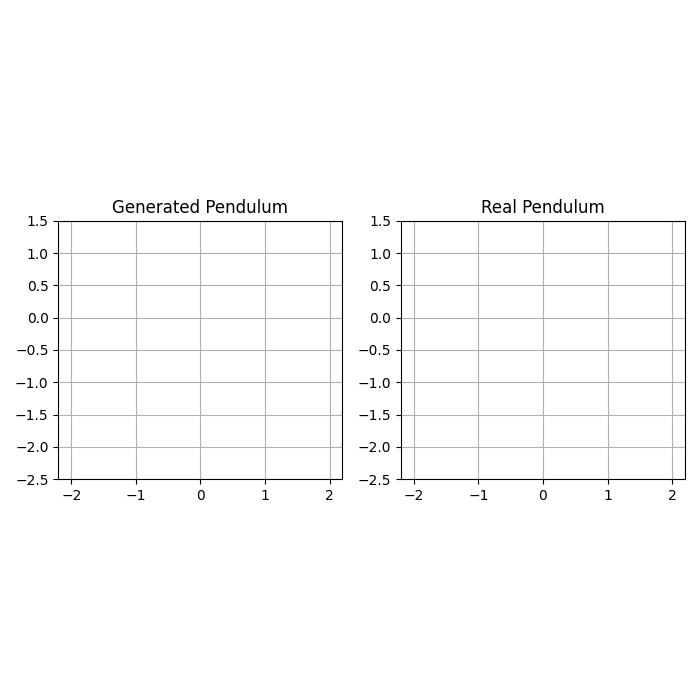

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# --- Pendulum lengths ---
l1, l2 = 1.0, 1.0

# --- Trajectory Data (already computed) ---
# X = full trajectory
# res = generated
# Y = ground truth
# test_steps, train_steps, warm_steps already defined

N = test_steps
Y = X[warm_steps + train_steps:]

# --- Helper: Convert angles to positions ---
def get_positions(data):
    th1, th2 = data[:, 0], data[:, 1]
    x1 = l1 * np.sin(th1)
    y1 = -l1 * np.cos(th1)
    x2 = x1 + l2 * np.sin(th2)
    y2 = y1 - l2 * np.cos(th2)
    return x1, y1, x2, y2

# --- Get both trajectories in Cartesian coordinates ---
x1_res, y1_res, x2_res, y2_res = get_positions(res)
x1_true, y1_true, x2_true, y2_true = get_positions(Y)

# --- Set up figure and axes ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7))

for ax in (ax1, ax2):
    ax.set_xlim(-2.2, 2.2)
    ax.set_ylim(-2.5, 1.5)
    ax.set_aspect('equal')
    ax.grid(True)

ax1.set_title("Generated Pendulum")
ax2.set_title("Real Pendulum")

# --- Initialize lines ---
gen_line1, = ax1.plot([], [], 'o-', lw=2, color='blue')
gen_line2, = ax1.plot([], [], 'o-', lw=2, color='red')

true_line1, = ax2.plot([], [], 'o-', lw=2, color='blue')
true_line2, = ax2.plot([], [], 'o-', lw=2, color='red')

# --- Initialization function ---
def init():
    gen_line1.set_data([], [])
    gen_line2.set_data([], [])
    true_line1.set_data([], [])
    true_line2.set_data([], [])
    return gen_line1, gen_line2, true_line1, true_line2

# --- Update function for animation ---
def update(frame):
    # Generated
    gen_line1.set_data([0, x1_res[frame]], [0, y1_res[frame]])
    gen_line2.set_data([x1_res[frame], x2_res[frame]], [y1_res[frame], y2_res[frame]])

    # Real
    true_line1.set_data([0, x1_true[frame]], [0, y1_true[frame]])
    true_line2.set_data([x1_true[frame], x2_true[frame]], [y1_true[frame], y2_true[frame]])

    return gen_line1, gen_line2, true_line1, true_line2

# --- Create animation ---
ani = FuncAnimation(fig, update, frames=N, init_func=init, blit=True, interval=20)

plt.tight_layout()
plt.show()
